 <center><h1> - Bank-marketing : Model selection & evaluation - </h1></center>

# 1-Predicting the outcome of the campaign



In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [51]:
VERBOSE = True
DATA_PATH = Path("../data")
PROCESSED_DATA_PATH = DATA_PATH / "processed" / "data_processed.csv"
PROCESSED_DATA_PATH1 = DATA_PATH / "processed" / "socio_eco_processed.csv"

In [52]:
data = pd.read_csv(PROCESSED_DATA_PATH)
if VERBOSE:
    display(data)

,date,age,job,relation,education,defaut,balance,pret_immo,pret_perso,contact,duree_contact,nb_contact,nb_j_dernier_contact,nb_contact_derniere_campagne,resultat_derniere_campagne,statut
0,2008-05-05,58,Manager,Marié,Tertiaire,No,2143,Yes,No,Autres,261,1,-1,0,not contacted,Refus
1,2008-05-05,123,Technicien,not available,Secondaire,No,29,Yes,not available,Autres,151,1,-1,0,not contacted,Refus
2,2008-05-05,33,Entrepreuneur,Marié,Secondaire,No,2,Yes,Yes,Autres,0,1,-1,0,not contacted,Absent
3,2008-05-05,47,Col bleu,Marié,not available,No,1506,Yes,No,Autres,0,1,-1,0,not contacted,Absent
4,2008-05-05,33,Autres,Célibataire,not available,No,1,No,No,Autres,198,1,-1,0,not contacted,Refus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45131,2010-10-27,47,Manager,Marié,Tertiaire,No,0,No,No,Portable,508,1,-1,0,not contacted,Souscrit
45132,2010-10-27,61,Retraité,Marié,Secondaire,No,1058,No,No,Portable,277,1,92,5,Succes,Refus
45133,2010-10-27,24,Etudiant,Célibataire,Secondaire,No,822,No,No,Portable,184,1,91,2,Echec,Souscrit
45134,2010-10-27,70,Retraité,Marié,Secondaire,No,0,No,No,Portable,258,1,92,5,Succes,Souscrit


In [54]:
soc = pd.read_csv(PROCESSED_DATA_PATH1)
if VERBOSE:
    display(soc)

,date,tx_var_emploi,idx_prix_conso,idx_conf_conso
0,2008-05-31,1.1,93.994000,-36.400000
1,2008-06-30,1.4,94.465000,-41.800000
2,2008-07-31,1.4,93.918000,-42.700000
3,2008-08-31,1.4,93.444000,-36.100000
4,2008-09-30,-0.1,93.621000,-38.250000
5,2008-10-31,-0.1,93.798000,-40.400000
6,2008-11-30,-0.1,93.200000,-42.000000
7,2008-12-31,-0.2,92.756000,-45.900000
8,2009-01-31,-0.2,92.785000,-47.266667
9,2009-02-28,-0.2,92.814000,-48.633333


In [57]:
# train_test split
#column_index_to_exclude = data.columns.get_loc('statut')
column_index_to_exclude = data.columns.get_loc('statut','duree_contact') #eliminate the most important feature so that maybe other features rise in importance
num_columns = data.shape[1]
columns_to_keep = [i for i in range(num_columns) if i != column_index_to_exclude]
X = data.iloc[:, columns_to_keep]
for column in X.columns:
    if X[column].dtype == "O":
        X[column] = X[column].astype("category").cat.codes
y = data["statut"].astype("category").cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# X.info()

C:\Users\chihi\AppData\Local\Temp\ipykernel_9372\2601080825.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = X[column].astype("category").cat.codes
C:\Users\chihi\AppData\Local\Temp\ipykernel_9372\2601080825.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = X[column].astype("category").cat.codes
C:\Users\chihi\AppData\Local\Temp\ipykernel_9372\2601080825.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [58]:
# Define the hyperparameters to be searched for each classifier
grid_params_svc = {
    "kernel": ["linear", "rbf"],
    "C": [0.1, 1, 10, 100],
}

grid_params_rf = {
    "n_estimators": [10, 50, 100, 200],
    "max_depth": [None, 5, 10, 15],
    "min_samples_split": [2, 5, 10],
}

grid_params_xgb = {
    "n_estimators": [10, 50, 100, 200],
    "max_depth": [3, 5, 10, 15],
    "learning_rate": [0.1, 0.01, 0.05],
}

grid_params_knn = {
    "n_neighbors": [3, 5, 7],
    "weights": ["uniform", "distance"],
    "p": [1, 2],
}


grid_params_dt = {
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

In [59]:
# Conduct grid search for each classifier
grid_dt = GridSearchCV(
    DecisionTreeClassifier(), grid_params_dt, cv=5, verbose=1, scoring="accuracy"
)

# grid_svc = GridSearchCV(SVC(), grid_params_svc, cv=5, verbose=1, scoring="accuracy")

# grid_rf = GridSearchCV(
#     RandomForestClassifier(), grid_params_rf, cv=5, verbose=1, scoring="accuracy"
# )

grid_xgb = GridSearchCV(
    XGBClassifier(), grid_params_xgb, cv=5, verbose=1, scoring="accuracy"
)

grid_knn = GridSearchCV(
    KNeighborsClassifier(), grid_params_knn, cv=5, verbose=1, scoring="accuracy"
)

In [60]:
# Fit the pipeline with the training data
grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy', verbose=1)

In [61]:
column_data_types = X_train.dtypes.unique()

# Print the unique data types
for data_type in column_data_types:
    print(data_type)

int16
int64
int8
int32
float64


In [62]:
grid_knn.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


D:\SoftwareDev\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
D:\SoftwareDev\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

D:\SoftwareDev\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
D:\SoftwareDev\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [63]:
# Fit the pipeline with the training data

# grid_rf.fit(X_train, y_train)

In [64]:
# Fit the pipeline with the training data

grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                   

In [65]:
# Fit the pipeline with the training data

# grid_svc.fit(X_train, y_train)

In [66]:
# Print the best parameters and best score for each classifier
# print("Best parameters for SVM: ", grid_svc.best_params_)
# print("Best score for SVM: ", grid_svc.best_score_)

# print("Best parameters for Random Forest: ", grid_rf.best_params_)
# print("Best score for Random Forest: ", grid_rf.best_score_)

print("Best parameters for XGBoost: ", grid_xgb.best_params_)
print("Best score for XGBoost: ", grid_xgb.best_score_)

print("Best parameters for KNN: ", grid_knn.best_params_)
print("Best score for KNN: ", grid_knn.best_score_)

print("Best parameters for decision tree: ", grid_dt.best_params_)
print("Best score for decision tree: ", grid_dt.best_score_)

Best parameters for XGBoost:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best score for XGBoost:  0.8494517226077315
Best parameters for KNN:  {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best score for KNN:  0.7940068834433985
Best parameters for decision tree:  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best score for decision tree:  0.8395645895876405


## 1-1  K-NN 

Accuracy of KNN classifier on training set: 1.00
Accuracy of KNN classifier on test set: 0.79

Classification Report of Classifier:

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3187
           1       0.00      0.00      0.00       154
           2       0.74      0.84      0.79      3947
           3       0.64      0.59      0.62      1063
           4       0.11      0.02      0.03       677

    accuracy                           0.79      9028
   macro avg       0.48      0.49      0.48      9028
weighted avg       0.73      0.79      0.76      9028



Text(0.5, 1.0, 'Confusion Matrix')

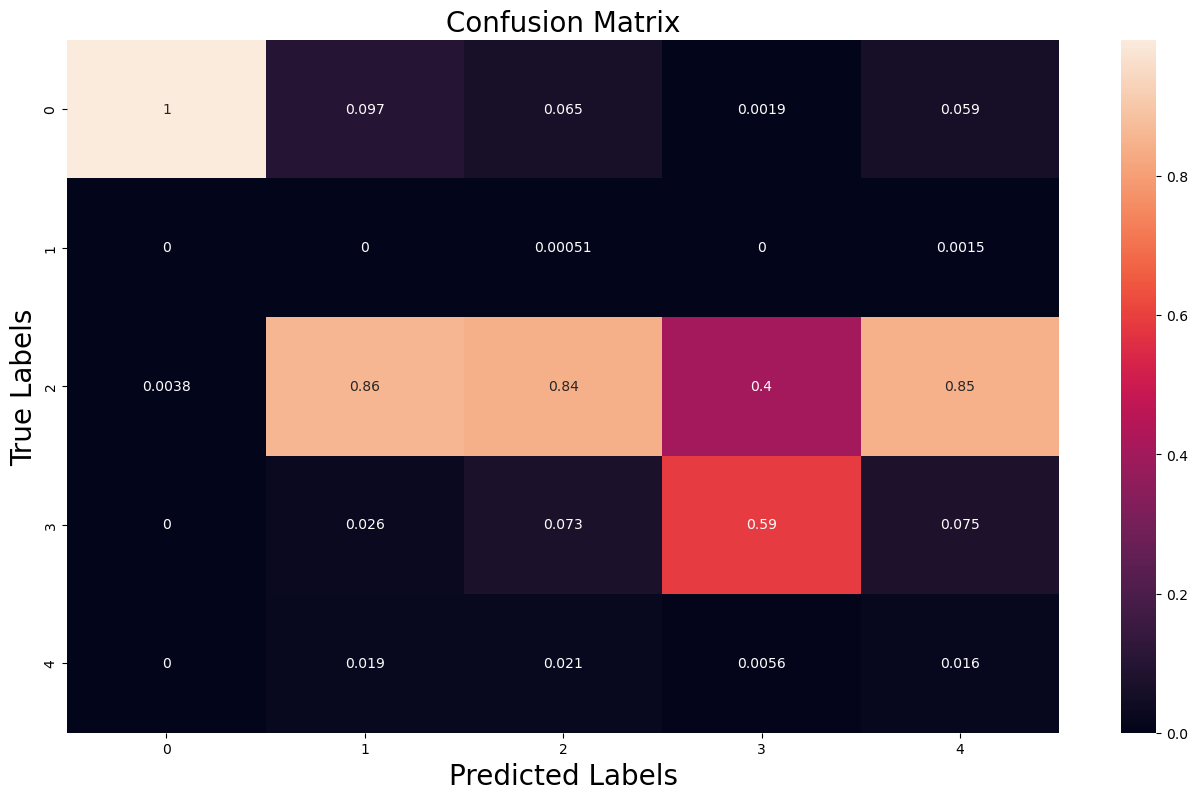

In [67]:
model_knn = grid_knn.best_estimator_
knn_pred = model_knn.predict(X_test)
print(
    "Accuracy of KNN classifier on training set: {:.2f}".format(
        model_knn.score(X_train, y_train)
    )
)
print(
    "Accuracy of KNN classifier on test set: {:.2f}".format(
        model_knn.score(X_test, y_test)
    )
)
print("\nClassification Report of Classifier:\n")
print(classification_report(y_test, knn_pred))

knn_matrix = confusion_matrix(knn_pred, y_test, normalize="pred")
plt.figure(figsize=(16, 9))
ax = plt.subplot()
sns.heatmap(knn_matrix, annot=True, ax=ax)

# labels, title and ticks
ax.set_xlabel("Predicted Labels", size=20)
ax.set_ylabel("True Labels", size=20)
ax.set_title("Confusion Matrix", size=20)

## 1-2 Decision tree
- We will build a decision tree model that will predict the outcome of the customer choice (wether to subscribe or not ..).
- We will use the model to figure out what features are the most important for determining the outcome. 
- Decision tree model was chosen because we can interpret the result and see exactly how the model makes the predictions. 
- The interpretability of the model process of "thought" is one of its most powerfull featuers and we will make sure to use that.

In [68]:
import graphviz
from sklearn.tree import export_graphviz


def plot_decision_tree(clf, feature_names, class_names):
    # This function requires the pydotplus module and assumes it's been installed.
    # In some cases (typically under Windows) even after running conda install, there is a problem where the
    # pydotplus module is not found when running from within the notebook environment.  The following code
    # may help to guarantee the module is installed in the current notebook environment directory.
    #
    # import sys; sys.executable
    # !{sys.executable} -m pip install pydotplus

    export_graphviz(
        clf,
        out_file="tree.dot",
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        impurity=False,
    )
    with open("tree.dot") as f:
        dot_graph = f.read()
    # Alternate method using pydotplus, if installed.
    # graph = pydotplus.graphviz.graph_from_dot_data(dot_graph)
    # return graph.create_png()
    return graphviz.Source(dot_graph)


def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names)

Accuracy of Decision Tree classifier on training set: 0.84
Accuracy of Decision Tree classifier on test set: 0.84

Classification Report of Classifier:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3187
           1       0.00      0.00      0.00       154
           2       0.76      0.93      0.84      3947
           3       0.68      0.64      0.66      1063
           4       0.00      0.00      0.00       677

    accuracy                           0.84      9028
   macro avg       0.49      0.52      0.50      9028
weighted avg       0.77      0.84      0.80      9028



D:\SoftwareDev\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\SoftwareDev\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\SoftwareDev\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Confusion Matrix')

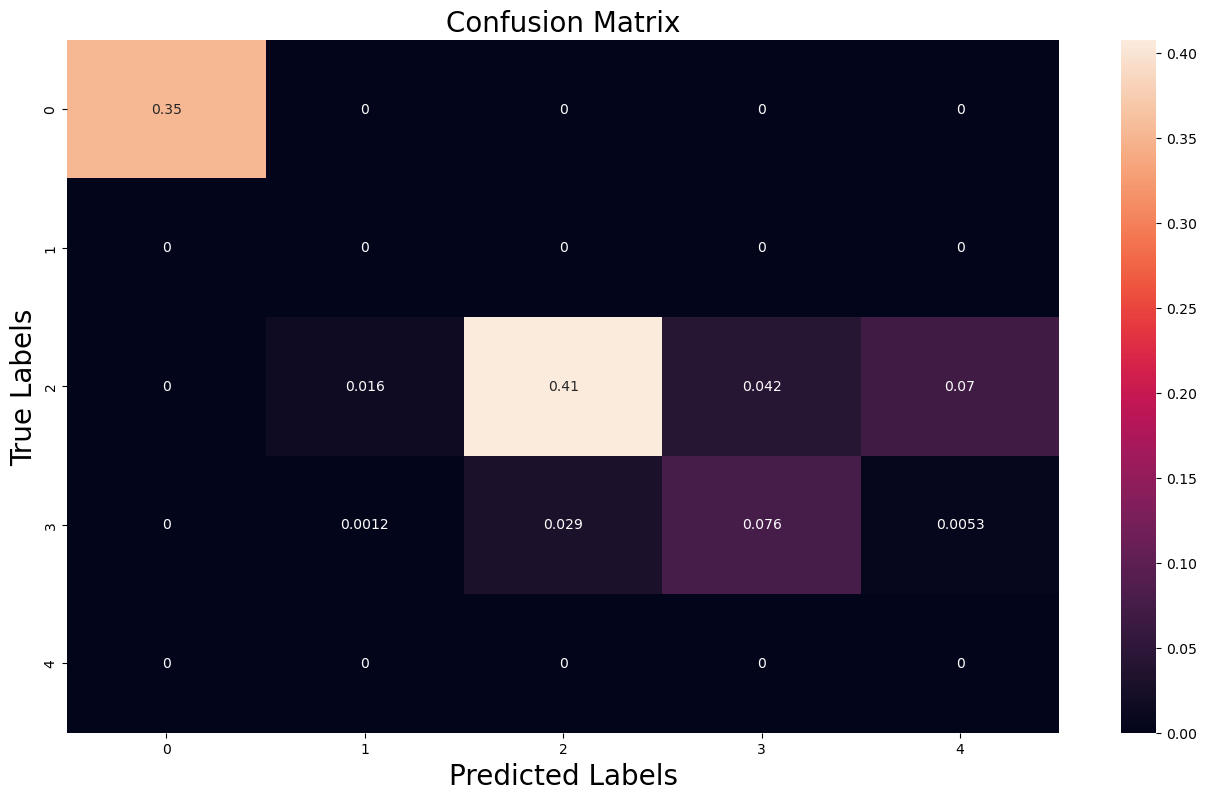

In [69]:
tree = grid_dt.best_estimator_
tree_pred=tree.predict(X_test)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(tree.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(tree.score(X_test, y_test)))
print("\nClassification Report of Classifier:\n")
print(classification_report(y_test, tree_pred))
tree_matrix = confusion_matrix(tree_pred, y_test, normalize='all')
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(tree_matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 

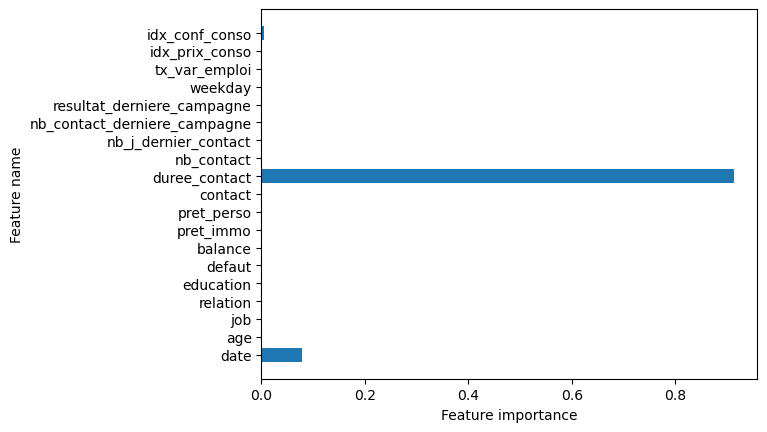

In [70]:
plot_feature_importances(tree, X.columns)

## 1-3 Random forest 

In [71]:
# model_rf = grid_rf.best_estimator_
# rf_pred = model_rf.predict(X_test)
# print(
#     "Accuracy of Random Forest on training set: {:.2f}".format(
#         model_rf.score(X_train, y_train)
#     )
# )
# print(
#     "Accuracy of Random Forest classifier on test set: {:.2f}".format(
#         model_rf.score(X_test, y_test)
#     )
# )
# print("\nClassification Report of Classifier:\n")
# print(classification_report(y_test, rf_pred))

# rf_matrix = confusion_matrix(rf_pred, y_test, normalize="pred")
# plt.figure(figsize=(16, 9))
# ax = plt.subplot()
# sns.heatmap(rf_matrix, annot=True, ax=ax)

# # labels, title and ticks
# ax.set_xlabel("Predicted Labels", size=20)
# ax.set_ylabel("True Labels", size=20)
# ax.set_title("Confusion Matrix", size=20)


## 1-4 XGBoost

Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 0.79

Classification Report of Classifier:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3187
           1       0.00      0.00      0.00       154
           2       0.78      0.93      0.85      3947
           3       0.70      0.73      0.72      1063
           4       0.00      0.00      0.00       677

    accuracy                           0.85      9028
   macro avg       0.49      0.53      0.51      9028
weighted avg       0.77      0.85      0.81      9028



D:\SoftwareDev\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\SoftwareDev\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\SoftwareDev\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Confusion Matrix')

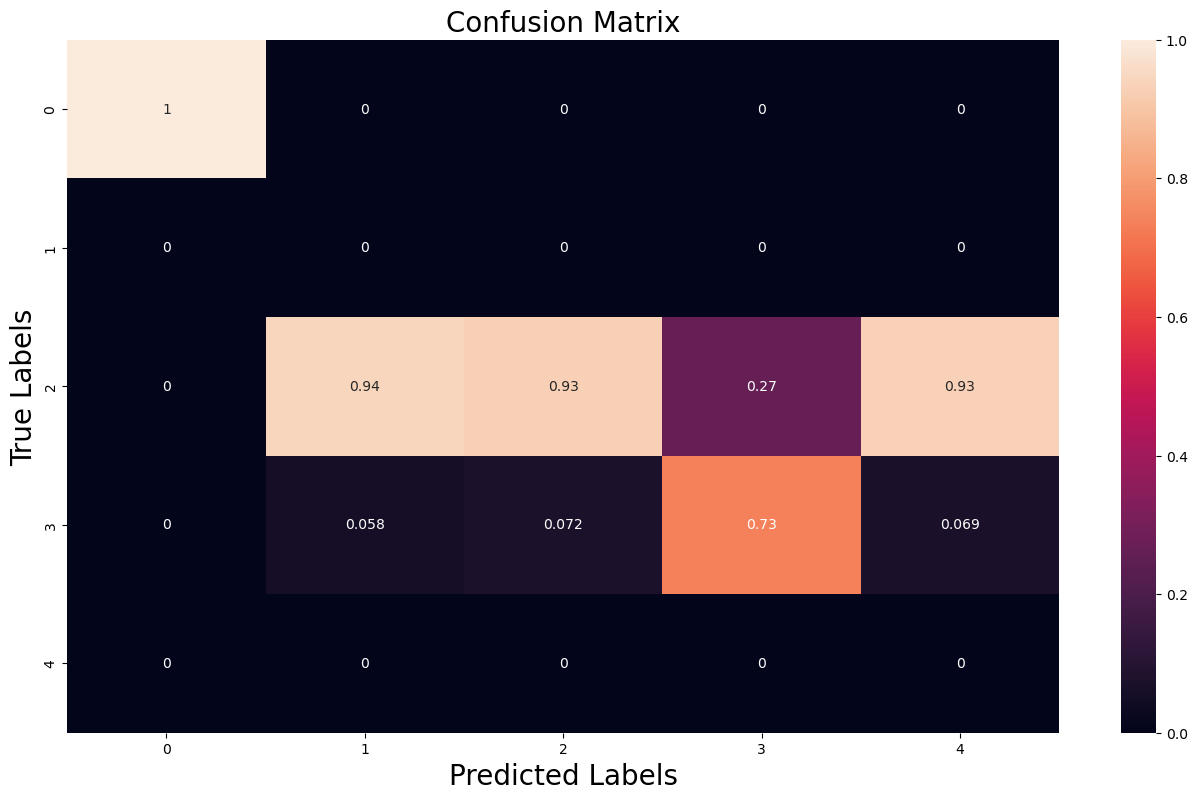

In [72]:
model_xgb = grid_xgb.best_estimator_
xgb_pred = model_xgb.predict(X_test)
print(
    "Accuracy of XGB classifier on training set: {:.2f}".format(
        model_knn.score(X_train, y_train)
    )
)
print(
    "Accuracy of XGB classifier on test set: {:.2f}".format(
        model_knn.score(X_test, y_test)
    )
)
print("\nClassification Report of Classifier:\n")
print(classification_report(y_test, xgb_pred))

xgb_matrix = confusion_matrix(xgb_pred, y_test, normalize="pred")
plt.figure(figsize=(16, 9))
ax = plt.subplot()
sns.heatmap(xgb_matrix, annot=True, ax=ax)

# labels, title and ticks
ax.set_xlabel("Predicted Labels", size=20)
ax.set_ylabel("True Labels", size=20)
ax.set_title("Confusion Matrix", size=20)

## 1-5 Support Vector Machine 

In [73]:
# model_svc = grid_svc.best_estimator_
# svc_pred = model_svc.predict(X_test)
# print(
#     "Accuracy of SVM classifier on training set: {:.2f}".format(
#         model_svc.score(X_train, y_train)
#     )
# )
# print(
#     "Accuracy of SVM classifier on test set: {:.2f}".format(
#         model_svc.score(X_test, y_test)
#     )
# )
# print("\nClassification Report of Classifier:\n")
# print(classification_report(y_test, svc_pred))

# svc_matrix = confusion_matrix(svc_pred, y_test, normalize="pred")
# plt.figure(figsize=(16, 9))
# ax = plt.subplot()
# sns.heatmap(svc_matrix, annot=True, ax=ax)

# # labels, title and ticks
# ax.set_xlabel("Predicted Labels", size=20)
# ax.set_ylabel("True Labels", size=20)
# ax.set_title("Confusion Matrix", size=20)

# 2-Results discussion 

* Dealing with unbalanced classes.
* Decision Tree: maybe hiding the duree contact from the model can allow other features to rise up in importance.